In [2]:
import torch

from Models_normal import *
from FeatureExtractor import *
from ForwardPass import *
from tqdm import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
from scipy.spatial import Delaunay
from shapely.geometry import Polygon, MultiLineString
from shapely.ops import unary_union

In [5]:
def pairwise_angles(points):
    # Ensure the points are tensors of float32 type
    if not isinstance(points, torch.Tensor):
        points = torch.tensor(points, dtype=torch.float32)

    # Compute dot products for all pairs
    dot_products = torch.matmul(points, points.T)  # Shape: (n, n)

    # Compute magnitudes of each vector
    magnitudes = torch.linalg.vector_norm(points, dim=1, keepdim=True)  # Shape: (n, 1)

    # Compute outer product of magnitudes to get all pairs of norms
    magnitude_products = torch.matmul(magnitudes, magnitudes.T)  # Shape: (n, n)

    # Calculate cosine of the angles, using clamp to handle numerical precision issues
    cos_theta = dot_products / magnitude_products
    cos_theta = torch.nan_to_num(cos_theta)
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)

    # Calculate the angles in radians (upper triangle only)
    angles_rad = torch.acos(cos_theta)  # Shape: (n, n)
    angles_rad = torch.triu(angles_rad, diagonal=1)  # Keep only the upper triangle, excluding the diagonal

    # Convert angles to degrees if needed
    angles_deg = torch.rad2deg(angles_rad)

    return angles_deg

In [4]:
# Example usage
points = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0],
    [-0.5, -0.5]
])

angles_deg = pairwise_angles(points)

print("Angles in degrees:\n", angles_deg)


Angles in degrees:
 tensor([[  0.,  90.,  45., 135.],
        [  0.,   0.,  45., 135.],
        [  0.,   0.,   0., 180.],
        [  0.,   0.,   0.,   0.]])


In [9]:
architecture = (2, [3, 3, 3, 3])

model = MLP_simple(n_in=architecture[0], layer_list=architecture[1])

feature_extractor = ReluExtractor(model, device=device)

In [10]:
relu_outputs = hook_forward(feature_extractor, points.to(device))

In [12]:
for hidden_out in relu_outputs:
    hidden_angles = pairwise_angles(hidden_out)
    print(hidden_angles[1])

tensor([[ 0.0000, 74.7394, 35.7707, 90.0000],
        [ 0.0000,  0.0000, 38.9687, 90.0000],
        [ 0.0000,  0.0000,  0.0000, 90.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0., 90.,  0., 90.],
        [ 0.,  0., 90., 90.],
        [ 0.,  0.,  0., 90.],
        [ 0.,  0.,  0.,  0.]], device='cuda:0')
tensor([[ 0.0000, 58.1003,  0.0000, 90.0000],
        [ 0.0000,  0.0000, 58.1003, 90.0000],
        [ 0.0000,  0.0000,  0.0000, 90.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[0.0000e+00, 6.9421e+01, 1.9782e-02, 7.0177e+01],
        [0.0000e+00, 0.0000e+00, 6.9421e+01, 4.0026e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0177e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0')


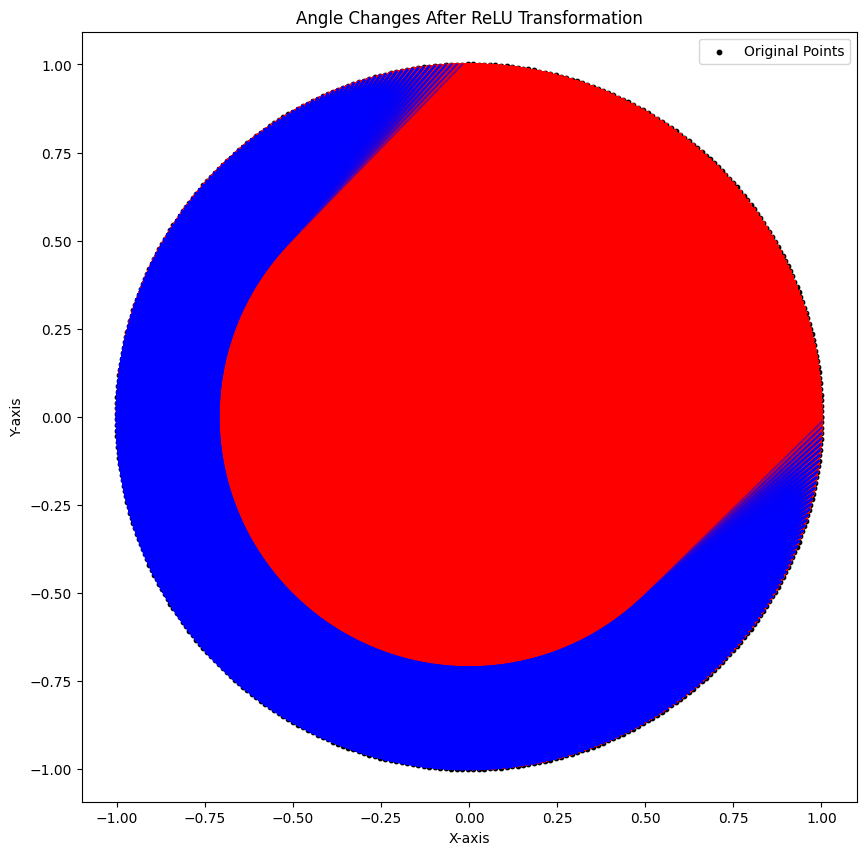

In [34]:
# Sample points on a 2D unit circle
num_points = 400
angles = torch.linspace(0, 2 * np.pi, num_points)
points = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)  # Shape: (num_points, 2)

# Calculate pairwise angles before ReLU transformation
angles_before_relu = pairwise_angles(points)

# Apply ReLU transformation
points_relu = torch.nn.functional.relu(points)

# Calculate pairwise angles after ReLU transformation
angles_after_relu = pairwise_angles(points_relu)

# Compare angles before and after ReLU
angle_diff = angles_after_relu - angles_before_relu

# Create a plot to visualize changes in angles
plt.figure(figsize=(10, 10))
for i in range(num_points):
    for j in range(i + 1, num_points):
        if angles_before_relu[i, j] != 0:  # Only consider upper triangle values
            # if angle_diff[i, j] > 0:
            #     plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-', alpha=0.5)  # Blue for increased angle
            if angle_diff[i, j] < 0:
                plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'r-', alpha=0.5)  # Red for decreased angle

for i in range(num_points):
    for j in range(i + 1, num_points):
        if angles_before_relu[i, j] != 0:  # Only consider upper triangle values
            if angle_diff[i, j] > 0:
                plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-', alpha=0.5)  # Blue for increased angle
            # if angle_diff[i, j] < 0:
            #     plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'r-', alpha=0.5)  # Red for decreased angle



# Plot the original points
plt.scatter(points[:, 0], points[:, 1], c='black', s=10, label='Original Points')
plt.title('Angle Changes After ReLU Transformation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

In [24]:
# Example usage
points = torch.tensor([
    [1, 0.0],
    [0, 1.0],
])
# Calculate pairwise angles before ReLU transformation
angles_before_relu = pairwise_angles(points)

# Apply ReLU transformation
points_relu = torch.nn.functional.relu(points)

# Calculate pairwise angles after ReLU transformation
angles_after_relu = pairwise_angles(points_relu)

# Compare angles before and after ReLU
angle_diff = angles_after_relu - angles_before_relu

print(angles_before_relu)
print(angles_after_relu)
print()

tensor([[ 0., 90.],
        [ 0.,  0.]])
tensor([[ 0., 90.],
        [ 0.,  0.]])



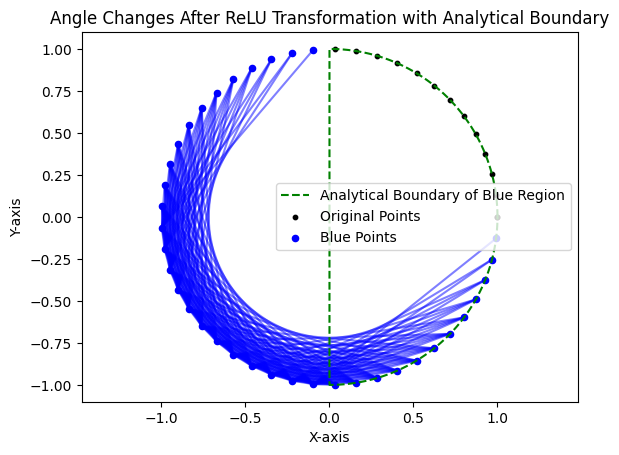

The blue region is defined by angles in the range [0, π/2] and [3π/2, 2π], corresponding to x > 0.


In [21]:
# Sample points on a 2D unit circle
num_points = 50
angles = torch.linspace(0, 2 * np.pi, num_points)
points = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)  # Shape: (num_points, 2)

# Calculate pairwise angles before ReLU transformation
angles_before_relu = pairwise_angles(points)

# Apply ReLU transformation
points_relu = torch.nn.functional.relu(points)

# Calculate pairwise angles after ReLU transformation
angles_after_relu = pairwise_angles(points_relu)

# Compare angles before and after ReLU
angle_diff = angles_after_relu - angles_before_relu

# Extract points involved in increased angles (blue lines)
blue_points = set()
for i in range(num_points):
    for j in range(i + 1, num_points):
        if angles_before_relu[i, j] != 0 and angle_diff[i, j] > 0:
            blue_points.add(i)
            blue_points.add(j)

blue_points = torch.tensor(list(blue_points), dtype=torch.long)
blue_points_coords = points[blue_points]

# Define the boundary of the blue region analytically
# The blue region is approximately where x > 0 and y is positive or slightly negative
boundary_angles = torch.linspace(0, np.pi / 2, 100).tolist() + torch.linspace(3 * np.pi / 2, 2 * np.pi, 100).tolist()
boundary_points = torch.stack([torch.cos(torch.tensor(boundary_angles)), torch.sin(torch.tensor(boundary_angles))], dim=1)

# # Create a plot to visualize changes in angles and the fitted boundary
# plt.figure(figsize=(10, 10))
# for i in range(num_points):
#     for j in range(i + 1, num_points):
#         if angles_before_relu[i, j] != 0:  # Only consider upper triangle values
#             if angle_diff[i, j] < 0:
#                 plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'r-', alpha=0.5)  # Red for decreased angle

for i in range(num_points):
    for j in range(i + 1, num_points):
        if angles_before_relu[i, j] != 0:  # Only consider upper triangle values
            if angle_diff[i, j] > 0:
                plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-', alpha=0.5)  # Blue for increased angle

# Plot the original points
plt.scatter(points[:, 0], points[:, 1], c='black', s=10, label='Original Points')

# Plot the blue points
plt.scatter(blue_points_coords[:, 0], blue_points_coords[:, 1], c='blue', s=20, label='Blue Points')

# Plot the boundary of the blue region
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'g--', label='Analytical Boundary of Blue Region')

plt.title('Angle Changes After ReLU Transformation with Analytical Boundary')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.axis('equal')
plt.show()

# Output the derived boundary description
print("The blue region is defined by angles in the range [0, π/2] and [3π/2, 2π], corresponding to x > 0.")


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0039, 0.0197, 0.0354, 0.0512, 0.0669, 0.0827, 0.0984, 0.1142,
        0.1299, 0.1457, 0.1614, 0.1772, 

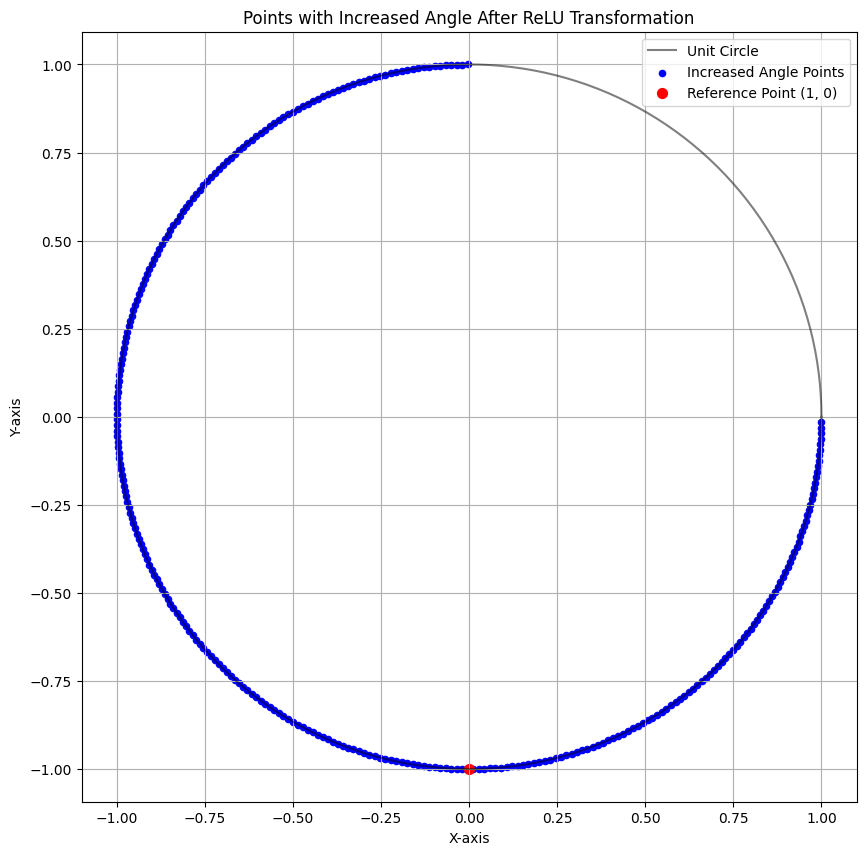

Point: (-0.004, 1.000), Angle Before: 3.138, Angle After: 3.142
Point: (-0.020, 1.000), Angle Before: 3.122, Angle After: 3.142
Point: (-0.035, 0.999), Angle Before: 3.106, Angle After: 3.142
Point: (-0.051, 0.999), Angle Before: 3.090, Angle After: 3.142
Point: (-0.067, 0.998), Angle Before: 3.075, Angle After: 3.142
Point: (-0.083, 0.997), Angle Before: 3.059, Angle After: 3.142
Point: (-0.098, 0.995), Angle Before: 3.043, Angle After: 3.142
Point: (-0.114, 0.993), Angle Before: 3.027, Angle After: 3.142
Point: (-0.130, 0.992), Angle Before: 3.012, Angle After: 3.142
Point: (-0.145, 0.989), Angle Before: 2.996, Angle After: 3.142
Point: (-0.161, 0.987), Angle Before: 2.980, Angle After: 3.142
Point: (-0.176, 0.984), Angle Before: 2.964, Angle After: 3.142
Point: (-0.192, 0.981), Angle Before: 2.949, Angle After: 3.142
Point: (-0.207, 0.978), Angle Before: 2.933, Angle After: 3.142
Point: (-0.223, 0.975), Angle Before: 2.917, Angle After: 3.142
Point: (-0.238, 0.971), Angle Before: 2.

In [18]:
def pairwise_angle(v1, v2):
    # Calculate cosine of the angle between two vectors
    dot_product = torch.dot(v1, v2)
    magnitude_v1 = torch.linalg.norm(v1)
    magnitude_v2 = torch.linalg.norm(v2)
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    cos_theta = torch.nan_to_num(cos_theta)

    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)  # Clamp to avoid numerical errors
    angle = torch.acos(cos_theta)
    return angle

# Sample points on a 2D unit circle
num_points = 400
angles = torch.linspace(0, 2 * np.pi, num_points)
points = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)  # Shape: (num_points, 2)

# Reference vector (1, 0)
v1 = torch.tensor([0.0, -1.0])

# Calculate angles before ReLU transformation
angles_before_relu = torch.tensor([pairwise_angle(v1, point) for point in points])

# Apply ReLU transformation
points_relu = torch.nn.functional.relu(points)

# Calculate angles after ReLU transformation
angles_after_relu = torch.tensor([pairwise_angle(v1, point) for point in points_relu])

# Compare angles before and after ReLU
angle_diff = angles_after_relu - angles_before_relu

print(angle_diff)
print(angle_diff.shape)

# Find points where the angle increased
increased_angle_indices = torch.where(angle_diff > 0)[0]
increased_points = points[increased_angle_indices]

# Visualize the points where the angle increased
plt.figure(figsize=(10, 10))
plt.plot(points[:, 0], points[:, 1], 'k-', alpha=0.5, label='Unit Circle')  # Plot the unit circle
plt.scatter(increased_points[:, 0], increased_points[:, 1], c='blue', s=20, label='Increased Angle Points')
plt.scatter(v1[0], v1[1], c='red', s=50, label='Reference Point (1, 0)')

plt.title('Points with Increased Angle After ReLU Transformation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Output the angles for reference
for idx in increased_angle_indices:
    print(f"Point: ({points[idx, 0].item():.3f}, {points[idx, 1].item():.3f}), Angle Before: {angles_before_relu[idx].item():.3f}, Angle After: {angles_after_relu[idx].item():.3f}")
